# Sign Language Detector using model_maker_object_detection Tensorflow

## 1)First you have to create data for training see ImageCollection file

## 2)  Download dependencies


In [1]:
!pip install "opencv-python-headless<4.3"
!pip install -q tflite-model-maker
!pip install -q tflite-support

     |████████████████████████████████| 21.6 MB 1.3 MB/s 
     |████████████████████████████████| 616 kB 29.7 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 596 kB 67.4 MB/s 
     |████████████████████████████████| 87 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 59.5 MB/s 
     |████████████████████████████████| 120 kB 78.2 MB/s 
     |████████████████████████████████| 840 kB 66.2 MB/s 
     |████████████████████████████████| 237 kB 67.5 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 6.4 MB 57.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.1 MB/s 
     |████████████████████████████████| 3.4 MB 55.1 MB/s 
     |████████████████████████████████| 25.3 MB 1.4 MB/s 
     |████████████████████████████████| 99 kB 11.0 MB/s 
     |████████████████████████████████| 352 kB 43.8 MB/s 
     |████████████████████████████████| 462 kB 70.6 MB/s 
     |█████████████

In [14]:
import numpy as np
import os
import cv2 
from PIL import Image

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## 3) Create Directories

In [3]:
# upload the images in these directories

os.mkdir('Images')
os.mkdir('Images/train')
os.mkdir('Images/test')

## 4)Load Data

In [6]:
train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir='Images/train',
    annotations_dir='Images/train',
    label_map=['hello', 'thumbsup','thumbsdown','nice']
)

val_data = object_detector.DataLoader.from_pascal_voc(
    images_dir='Images/test',
    annotations_dir='Images/test',
    label_map=['hello', 'thumbsup','thumbsdown','nice']
)

In [7]:
train_data.size

54

## 5) Get the Model

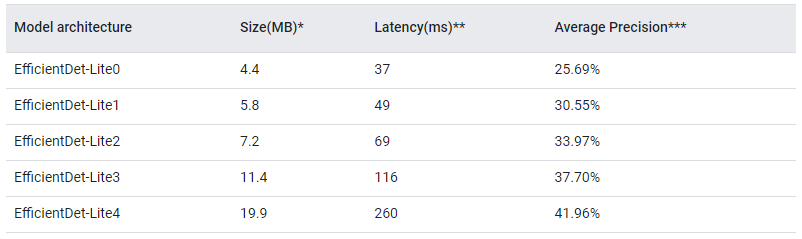

You can select any architecture from these

In [9]:
spec = model_spec.get('efficientdet_lite0')

## 6) Training

In [10]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=100, validation_data=val_data)

Epoch 1/100
13/13 [==============================] - 45s 520ms/step - det_loss: 1.7214 - cls_loss: 1.1509 - box_loss: 0.0114 - reg_l2_loss: 0.0634 - loss: 1.7848 - learning_rate: 0.0065 - gradient_norm: 2.5991 - val_det_loss: 1.6971 - val_cls_loss: 1.1313 - val_box_loss: 0.0113 - val_reg_l2_loss: 0.0634 - val_loss: 1.7605
Epoch 2/100
13/13 [==============================] - 4s 302ms/step - det_loss: 1.6081 - cls_loss: 1.1191 - box_loss: 0.0098 - reg_l2_loss: 0.0634 - loss: 1.6715 - learning_rate: 0.0050 - gradient_norm: 2.7311 - val_det_loss: 1.5919 - val_cls_loss: 1.1050 - val_box_loss: 0.0097 - val_reg_l2_loss: 0.0634 - val_loss: 1.6553
Epoch 3/100
13/13 [==============================] - 4s 310ms/step - det_loss: 1.5097 - cls_loss: 1.0651 - box_loss: 0.0089 - reg_l2_loss: 0.0634 - loss: 1.5731 - learning_rate: 0.0050 - gradient_norm: 2.9266 - val_det_loss: 1.4753 - val_cls_loss: 1.0292 - val_box_loss: 0.0089 - val_reg_l2_loss: 0.0634 - val_loss: 1.5387
Epoch 4/100
13/13 [===========

## 7) Evaluate the Model

In [11]:
model.evaluate(val_data)

1/1 [==============================] - 7s 7s/step



{'AP': 0.75984055,
 'AP50': 1.0,
 'AP75': 0.87376237,
 'AP_/hello': 0.87882286,
 'AP_/nice': 0.6876945,
 'AP_/thumbsdown': 0.6978943,
 'AP_/thumbsup': 0.7749505,
 'APl': 0.7602306,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.80833334,
 'ARm': -1.0,
 'ARmax1': 0.77916664,
 'ARmax10': 0.8,
 'ARmax100': 0.80833334,
 'ARs': -1.0}

Metrics for evaluting the model these metrics are used by COCO

Average Precision (AP):

AP Across Scales:

Average Recall (AR):

AR Across Scales:

For further detail check this:
https://cocodataset.org/#detection-eval

## 8) Export Model in tflite format

In [12]:
model.export(export_dir='.', tflite_filename='model.tflite')

## 9) Check  Model on an Image 

In [13]:
model_path = 'model.tflite'
classes = ['???'] * model.model_spec.config.num_classes

label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

classes

['hello', 'thumbsup', 'thumbsdown', 'nice']

In [15]:
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

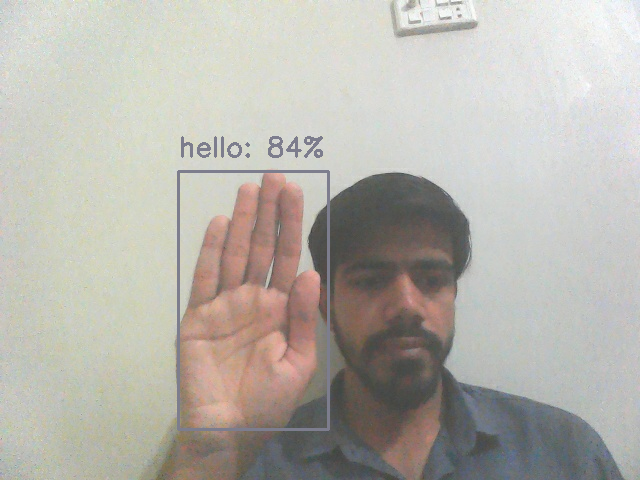

In [16]:
# Specify the threshold
DETECTION_THRESHOLD = 0.3

IMAGE_PATH = '/content/Images/test/hello5.jpg'


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


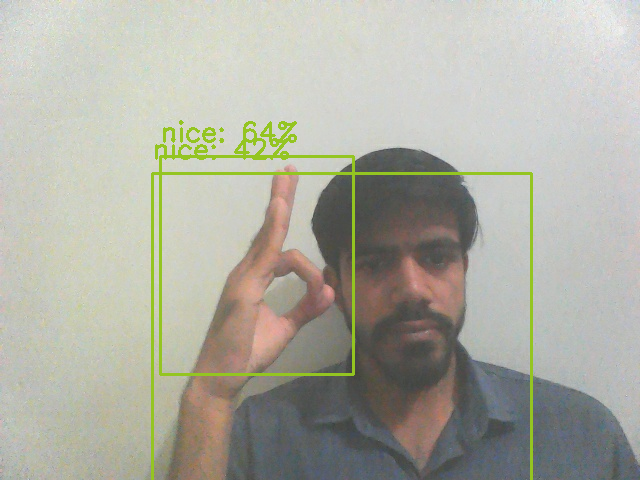

In [19]:
# Specify the threshold
DETECTION_THRESHOLD = 0.3

IMAGE_PATH = '/content/Images/test/nice5.jpg'


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


## Here you can see that model is detecting multiple anchor boxes try with different Threshold value and see which threshold gives you the better results.

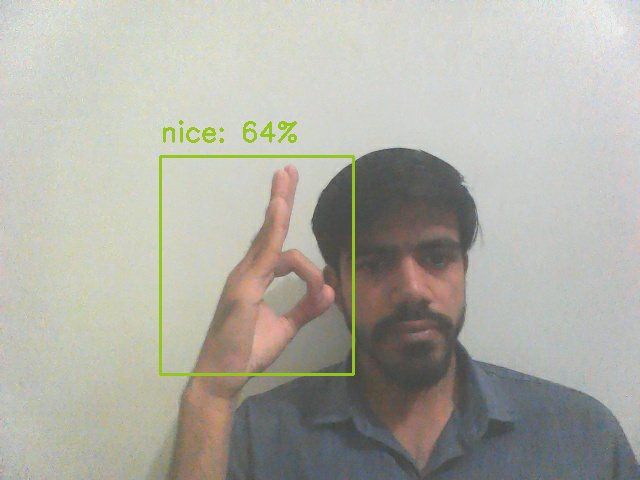

In [20]:
# Specify the threshold
# Change threshold to 0.5 and let see the results
DETECTION_THRESHOLD = 0.5

IMAGE_PATH = '/content/Images/test/nice5.jpg'


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


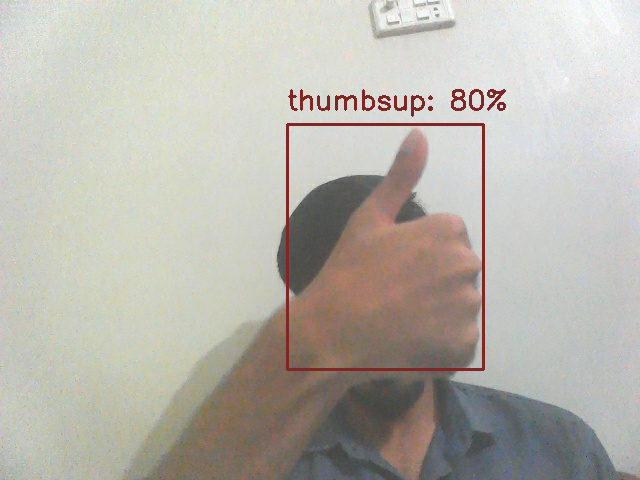

In [22]:
# Specify the threshold
DETECTION_THRESHOLD = 0.5

IMAGE_PATH = '/content/Images/test/thumbsup5.jpg'


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


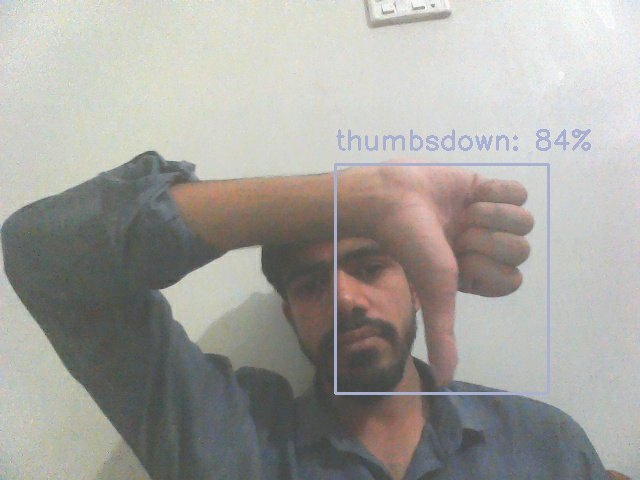

In [24]:
# Specify the threshold
# Change threshold to 0.5 and let see the results
DETECTION_THRESHOLD = 0.5

IMAGE_PATH = '/content/Images/test/thumpsdown4.jpg'


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    IMAGE_PATH,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)
